
> 📁 **Note**: Make sure the dataset is placed in the `data/` directory following this structure:
>
> ```
> data/
> ├── train/
> │   ├── cats/
> │   └── dogs/
> ├── validation/
> │   ├── cats/
> │   └── dogs/
> └── test/
>     ├── cats/
>     └── dogs/
> ```

This notebook trains a binary image classifier using CNNs to distinguish between cats and dogs using TensorFlow and Keras.


In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

2.8.0


In [2]:
base_dir = 'data'

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [5]:
print("Total training cats images:", len(os.listdir(train_cats_dir)))
print("Total training dogs images:", len(os.listdir(train_dogs_dir)))

print("Total validation cats images:", len(os.listdir(validation_cats_dir)))
print("Total validation dogs images:", len(os.listdir(validation_dogs_dir)))

print("Total test cats images:", len(os.listdir(test_cats_dir)))
print("Total test dogs images:", len(os.listdir(test_dogs_dir)))

Total training cats images: 1000
Total training dogs images: 1000
Total validation cats images: 500
Total validation dogs images: 500
Total test cats images: 500
Total test dogs images: 500


## 🔁 Transfer Learning and Fine-Tuning

In this project, we use a **pre-trained model** to help classify images of cats and dogs. A pre-trained model has already learned how to recognize general features in images, because it was trained on a very large dataset (like ImageNet).

At first, we **freeze** the pre-trained model. This means we don’t change its weights, and we only train the new layers we add on top (the classifier).

Then, we do something called **fine-tuning**. We **unfreeze the last few layers** of the pre-trained model and train them again. This helps the model learn better for our specific dataset.

Fine-tuning improves accuracy by adjusting the higher-level features to fit our cat vs dog classification task.

In [6]:
#Transfer-Learning
pre_trained_model = VGG16(input_shape=(150,150,3),# You can increase the input size to potentially improve accuracy, but it will also increase training time and require better hardware.
                         include_top = False, 
                         weights = 'imagenet') 

In [7]:
# Fine-Tunning
pre_trained_model.trainable = True

set_trainable = False

for layer in pre_trained_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## 🔚 Output Layer and Activation Function

Since this is a **binary classification** problem (cat vs dog), we use the **`sigmoid`** activation function in the final layer of the model.

The `sigmoid` function returns a value between **0 and 1**, which we can interpret as a **probability**. For example:

- If the output is close to **1**, the model predicts the image is a **dog**
- If the output is close to **0**, the model predicts the image is a **cat**

This helps us decide the final class using a simple rule:

```python
if prediction > 0.5:
    label = "dog"
else:
    label = "cat"

In [8]:
model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [9]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


## ⚙️ Compiling the Model

Before training a deep learning model, we need to **compile** it. This step tells the model how it should learn. During compilation, we define three main things:

1. **Loss Function**:  
   This measures how far the model’s predictions are from the actual values.  
   For binary classification, we usually use:
   - `binary_crossentropy`

2. **Optimizer**:  
   This decides how the model updates its weights during training. It controls how fast or slow the model learns.  

3. **Metrics**:  
   These are used to evaluate the performance of the model during training and testing.  
   For classification tasks, we usually monitor:
   - `accuracy`

In [11]:
model.compile(loss = 'binary_crossentropy',
             optimizer = RMSprop(learning_rate=1e-4),
             metrics = ['accuracy'])

## 📉 Callbacks

To improve model performance and training stability, we use several callbacks provided by Keras:

- **EarlyStopping**: Stops training when the validation loss stops improving, helping to prevent overfitting.
- **ModelCheckpoint**: Saves the model with the best validation performance during training.
- **ReduceLROnPlateau**: Reduces the learning rate when the validation loss stops improving, allowing the model to converge more effectively.

In this model I'm not training it with all the callbacks defined, you can try with different callbacks and use the one with the best results.

These callbacks are essential tools when training deep learning models, especially when dealing with limited datasets or noisy data.


## ❓ Why Do We Use Callbacks? 

They can also help the model escape from **local minima** by reducing the learning rate dynamically.

The **learning rate** controls how much the model updates its weights after each epoch — a smaller learning rate can lead to more precise learning, while a higher one speeds up training but may miss the optimal solution.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=10,           
    restore_best_weights=True  
)

from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5', 
    monitor='val_loss',        
    save_best_only=True,       
    mode='min',
    verbose=1
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,                
    patience=3,                
    min_lr=1e-6,               
    verbose=1                  
)


## 🖼️ Data Augmentation

Since our dataset is relatively small, we use **data augmentation** to generate more training examples from the existing images. This helps the model generalize better and avoid overfitting.

With Keras' `ImageDataGenerator`, we apply random transformations such as:

- Rotation
- Width and height shift
- Shearing
- Zooming
- Horizontal and vertical flipping

These transformations create slightly modified versions of the original images, making the model more robust and improving its performance on unseen data.

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255, # Sirve para trabjar con 0 y 1
                                   rotation_range = 40,
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   target_size= (150,150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             batch_size = 20,
                                                             class_mode = 'binary',
                                                             target_size = (150,150))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   target_size= (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 🧠 Model Training

With the dataset prepared and callbacks configured (they helps us to prevent the overfitting), we proceed to train the model.

The training is performed using the `model.fit()` method, where we provide the training and validation datasets, the number of epochs, batch size, and the callbacks defined earlier.

The goal is to optimize the model's ability to classify images of cats and dogs by minimizing the validation loss and maximizing accuracy. The callbacks help in dynamically adjusting training behavior, such as stopping early if performance stagnates or adapting the learning rate when needed.

The training process is visualized through plots to monitor accuracy and loss across epochs.

In [15]:
batch_size = 20
steps_per_epochs = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
print(steps_per_epochs)
print(validation_steps)

100
50


In [16]:
history = model.fit(train_generator,
                   steps_per_epoch = steps_per_epochs,
                   epochs = 100,
                   validation_data = validation_generator,
                   validation_steps = validation_steps,
                    callbacks = [early_stopping, model_checkpoint, reduce_lr]
                   )

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.6770
Epoch 1: val_loss improved from inf to 0.33879, saving model to best_model.h5
100/100 [==============================] - 22s 165ms/step - loss: 0.6154 - accuracy: 0.6770 - val_loss: 0.3388 - val_accuracy: 0.8690 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.7950
Epoch 2: val_loss improved from 0.33879 to 0.25229, saving model to best_model.h5
100/100 [==============================] - 17s 169ms/step - loss: 0.4361 - accuracy: 0.7950 - val_loss: 0.2523 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8275
Epoch 3: val_loss did not improve from 0.25229
100/100 [==============================] - 16s 155ms/step - loss: 0.3897 - accuracy: 0.8275 - val_loss: 0.2662 - val_accuracy: 0.8870 - lr: 1.0000e-04
Epoch 4/100
100/100 [============================

## 📈 Training Metrics Visualization

In the following plots, you can see how the model's **accuracy** and **loss** evolved during the training process.

We track two key metrics:

- **Accuracy** – how often the model's predictions were correct.
- **Loss** – how far the predictions were from the true labels.

This two metrics are important because we can understand how well the model is learning and wehter it's overfitting and underfitting. 

## 🧠 Detecting Overfitting and Underfitting

- **Overfitting** occurs when the model performs well on the training data but poorly on the validation data.  
  This usually happens when the training accuracy keeps increasing, but the validation accuracy stops improving or even starts to drop.

  <span style="color:red"><strong>The biggest problem with overfitting is that our model is memorizing the training data, but it can't generalize when we validate what the model has learned or make predictions on test data.</strong></span>


- **Underfitting** happens when the model is too simple or hasn't trained enough to learn from the data.  
  In this case, both training and validation accuracy remain low, and the model doesn't improve over time.

By visualizing the training and validation metrics, we can identify these issues and apply techniques like regularization, data augmentation, or early stopping to improve performance.

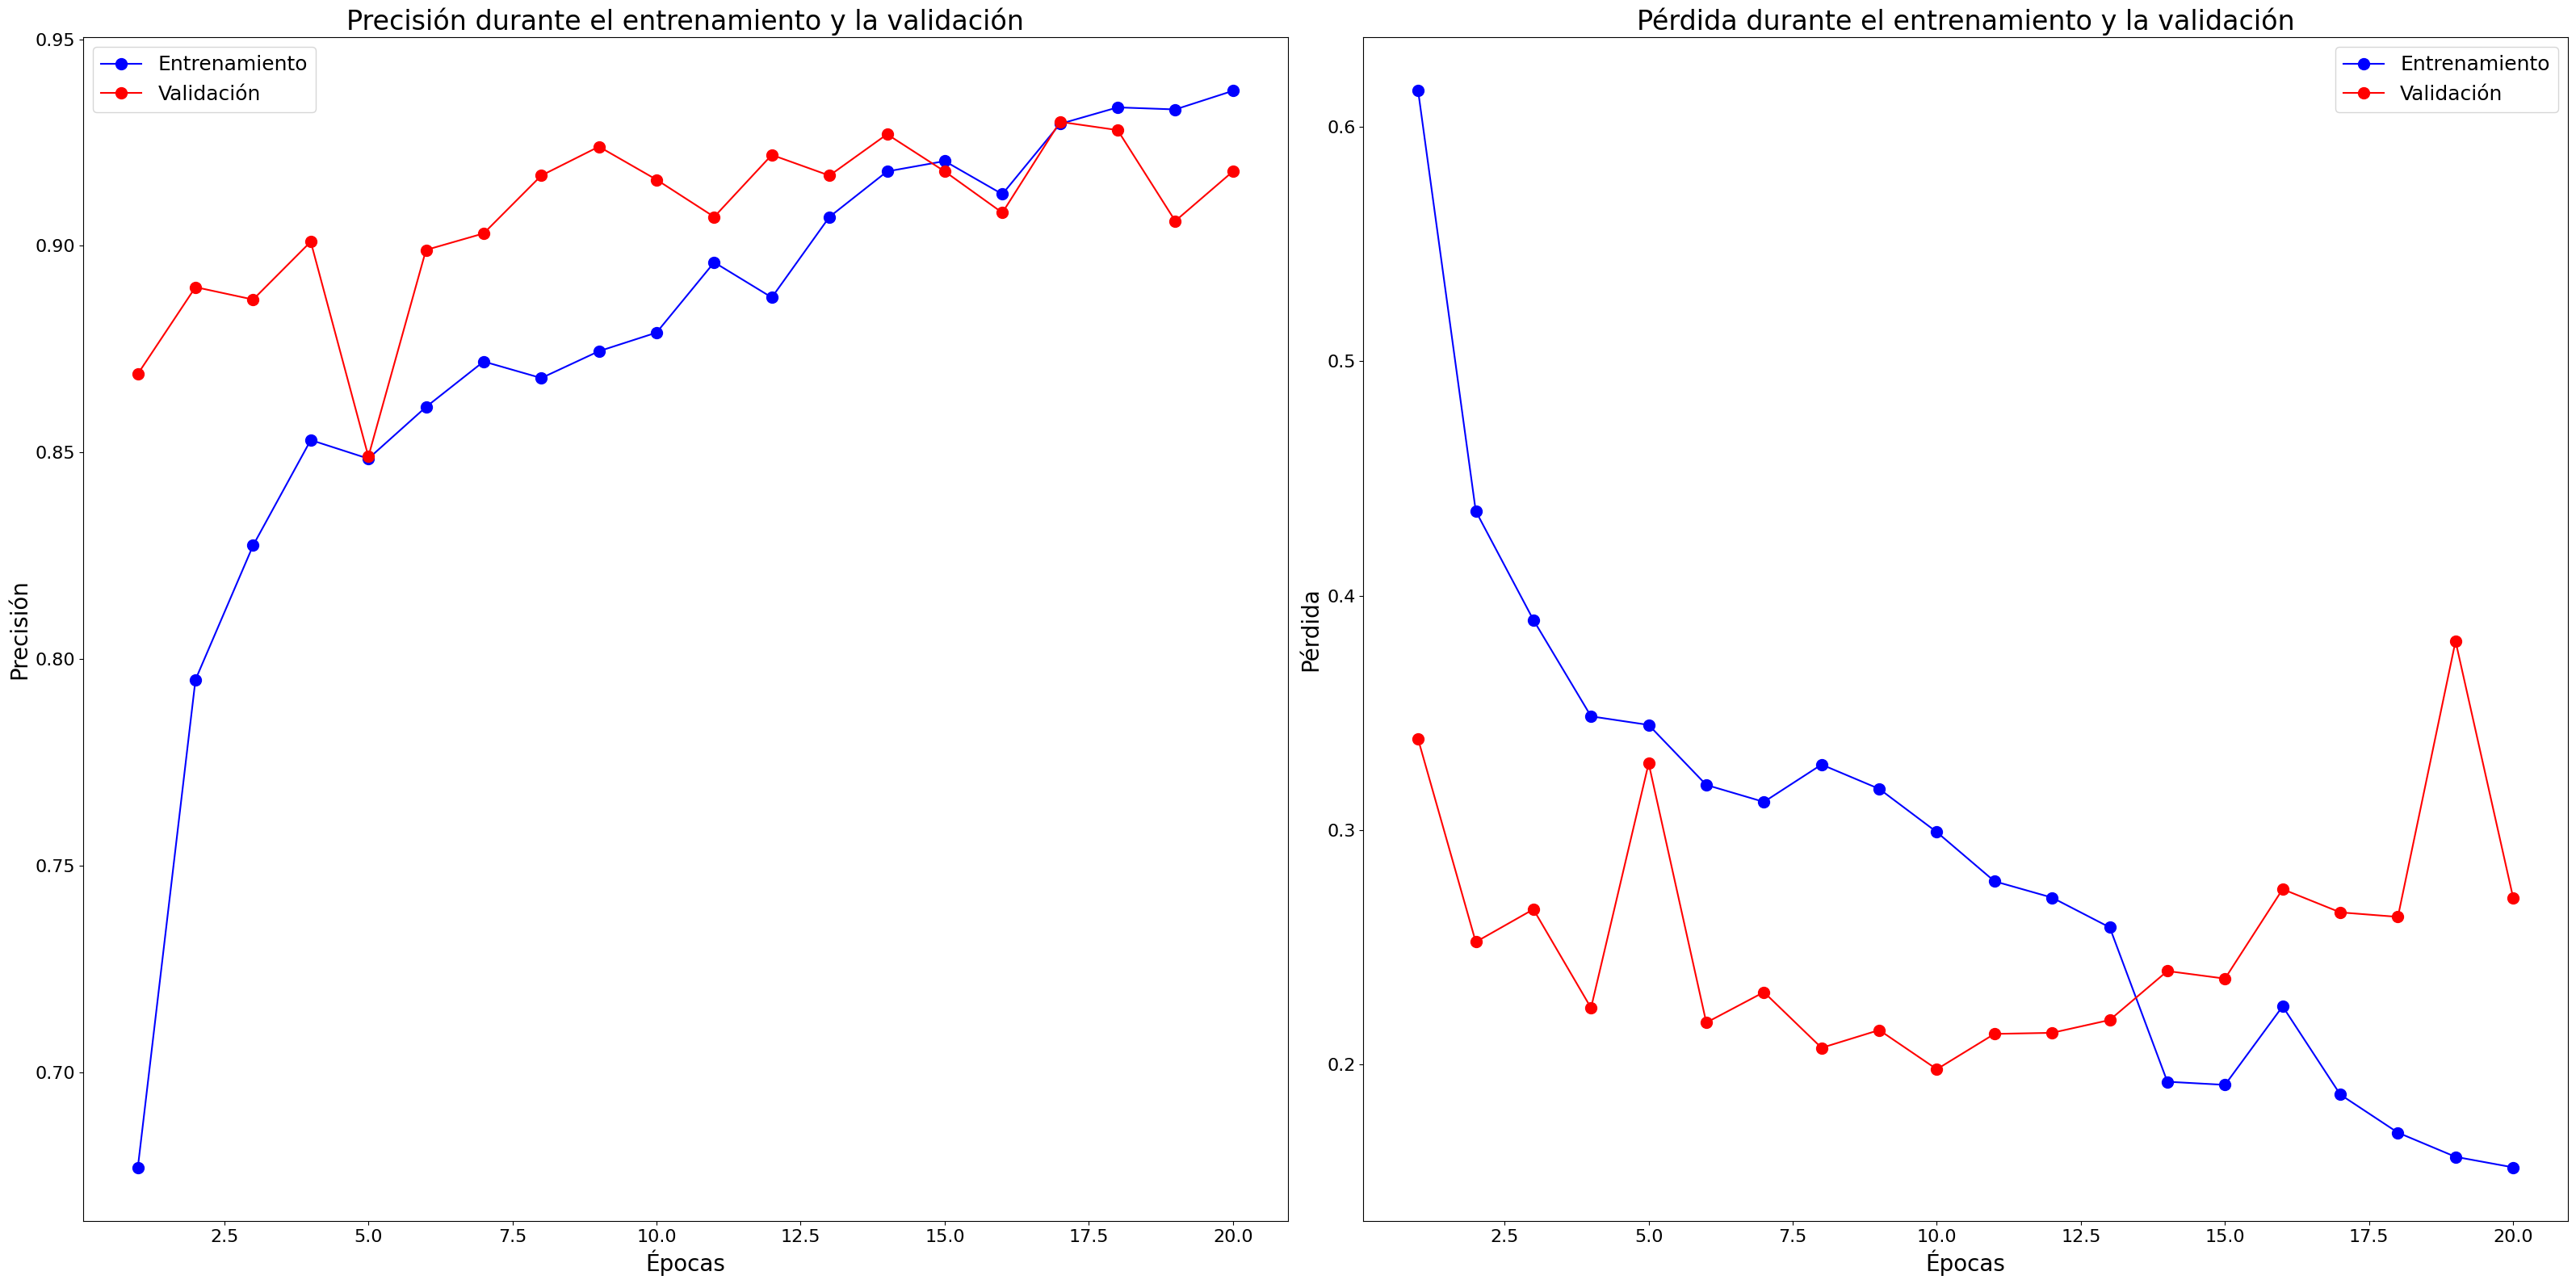

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(32, 16))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento', markersize=10)  
plt.plot(epochs, val_acc, 'ro-', label='Validación', markersize=10)  
plt.title('Precisión durante el entrenamiento y la validación', fontsize=24)  
plt.xlabel('Épocas', fontsize=20) 
plt.ylabel('Precisión', fontsize=20)  
plt.legend(fontsize=18) 
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento', markersize=10)  
plt.plot(epochs, val_loss, 'ro-', label='Validación', markersize=10)  
plt.title('Pérdida durante el entrenamiento y la validación', fontsize=24)  
plt.xlabel('Épocas', fontsize=20)  
plt.ylabel('Pérdida', fontsize=20)  
plt.legend(fontsize=18)  
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

plt.tight_layout()  
plt.show()


## 🧪 Model Evaluation and Predictions

After training, we evaluate how well the model performs on **unseen test data** using the `evaluate()` function. This gives us a final measurement of the model's **loss and accuracy** on data it has never seen before.

We also use the model to **make predictions** on test images with the `predict()` function. These predictions are probability values (between 0 and 1) because we used the `sigmoid` activation function in the output layer.

To interpret the results:
- Values closer to **1** mean the model predicts the image is a **dog**
- Values closer to **0** mean it predicts a **cat**

We can then compare these predictions to the actual labels to check the model's performance, plot confusion matrices, or visualize some sample results to better understand the model's behavior.

This step is important to verify if the model generalizes well to new data and to detect any possible issues like overfitting.


In [18]:
test_loss, test_acc = model.evaluate(test_generator)

50/50 [==============================] - 3s 49ms/step - loss: 0.3410 - accuracy: 0.9100


## 🤔 Is This a Good Accuracy?

Whether the model's accuracy is "good" always depends on the context and the task.

For example, if the average **human accuracy** in detecting breast cancer is around 50%, and a model achieves 70–80%, then the model is already performing significantly better than a human — and is therefore considered effective.

In this project, we can probably improve the model’s performance by experimenting with different **optimizers**, **callbacks**, or **batch sizes**. However, one of the most critical factors is the **amount of training data** available.

Here, we are working with a relatively small dataset:  
**4,000 total images**, with **2,000 cats** and **2,000 dogs**.

If we had more images, the model could potentially generalize better, reach higher accuracy, and **delay the onset of overfitting**.


In [19]:
print("Accuracy: ", test_acc)

Accuracy:  0.9100000262260437


In [20]:
predictions = model.predict(test_generator)

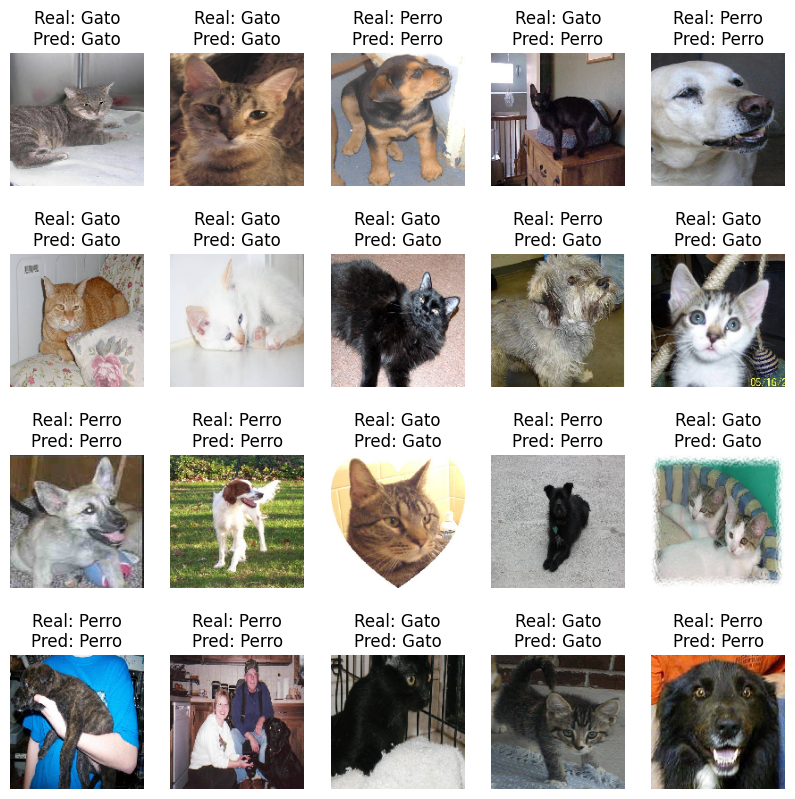

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get a specific batch through an index from the test dataset generated by ImageGenerator
images, labels = test_generator[12]  

# Make predictions
predictions = model.predict(images)

plt.figure(figsize=(10, 10))

# Dictionary with labels names
label_dict = {0: 'Gato', 1: 'Perro'}

for i in range(len(images)):
    plt.subplot(4, 5, i + 1) 
    plt.imshow(images[i], cmap=plt.cm.binary)

    
    pred_label = int(predictions[i] > 0.5)

    
    plt.title(f"Real: {label_dict[int(labels[i])]}\nPred: {label_dict[pred_label]}")
    plt.axis('off') 

plt.show()

## 💾 Save the Model

If you want to reuse this model later — for deployment, testing, or integration into another application — make sure to save it using the following command:

```python
model.save("your_model_name.h5")